In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
#导入库

In [2]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [ ]:
#加载 MNIST 数据，MNIST 数字图像作为视觉刺激（stimulus），对应人类看到手写数字时 V1/V2 的响应过程。

In [3]:
class V1V2_CNN(nn.Module):
    def __init__(self):
        super(V1V2_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = V1V2_CNN().to(device)
model



V1V2_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
#定义两层CNN，第一层卷积模拟 V1 simple cells，有小的感受野；对特定方向的边缘有最大响应；是视觉皮层的第一层处理节点
#第二层卷积模拟模拟 V2 complex cells，感受野更大，对组合形状（交叉、角点、笔画）敏感，比 V1 更抽象，更高层次。
#最终卷积提取的特征分类数字，对应大脑的IT 区 / 决策层

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total, correct = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            _, p = torch.max(pred, 1)
            total += y.size(0)
            correct += (p == y).sum().item()

        print(f"Epoch {epoch+1}: Acc={correct/total:.4f}")

train(model, train_loader)


Epoch 1: Acc=0.9432
Epoch 2: Acc=0.9821
Epoch 3: Acc=0.9880
Epoch 4: Acc=0.9897
Epoch 5: Acc=0.9917


In [ ]:
#训练网络进行学习，对应视觉皮层通过经验学习形成方向选择性，权重改变，多次训练后，大脑能够识别数字

In [7]:
def test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            _, p = torch.max(pred, 1)
            total += y.size(0)
            correct += (p == y).sum().item()

    print("Test accuracy:", correct/total)

test(model, test_loader)

Test accuracy: 0.99


In [ ]:
#评估模型在未见过的数据上的表现，类比“大脑识别新数字的能力”。模型越好说明V1 和 V2 层级特征提取越有效，视觉通路加工效率越高。

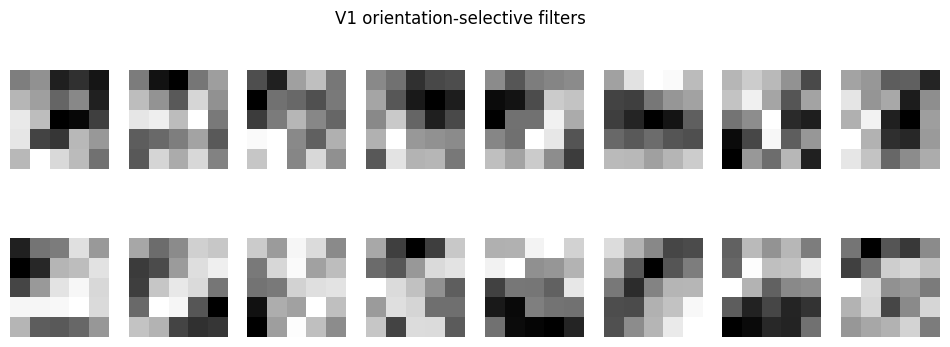

In [8]:
filters = model.conv1.weight.data.cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(12, 4))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(filters[i, 0], cmap='gray')
    axes[i].axis('off')

plt.suptitle("V1 orientation-selective filters")
plt.show()

In [ ]:
#可视化卷积核，展示 V1 simple cells 的方向选择性，每个卷积核代表一个“边缘检测器”

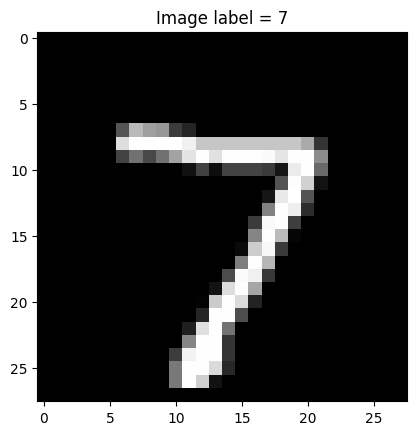

In [9]:
image, label = next(iter(test_loader))
image = image[0:1].to(device)

plt.imshow(image[0,0].cpu(), cmap='gray')
plt.title(f"Image label = {label[0].item()}")
plt.show()

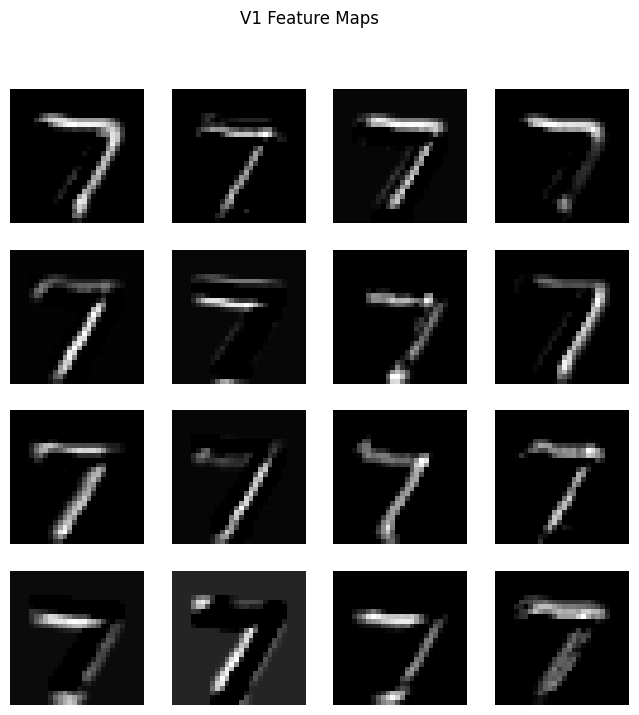

In [10]:
with torch.no_grad():
    v1_act = model.relu1(model.conv1(image)).cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(v1_act[0, i], cmap='gray')
    axes[i].axis('off')

plt.suptitle("V1 Feature Maps")
plt.show()

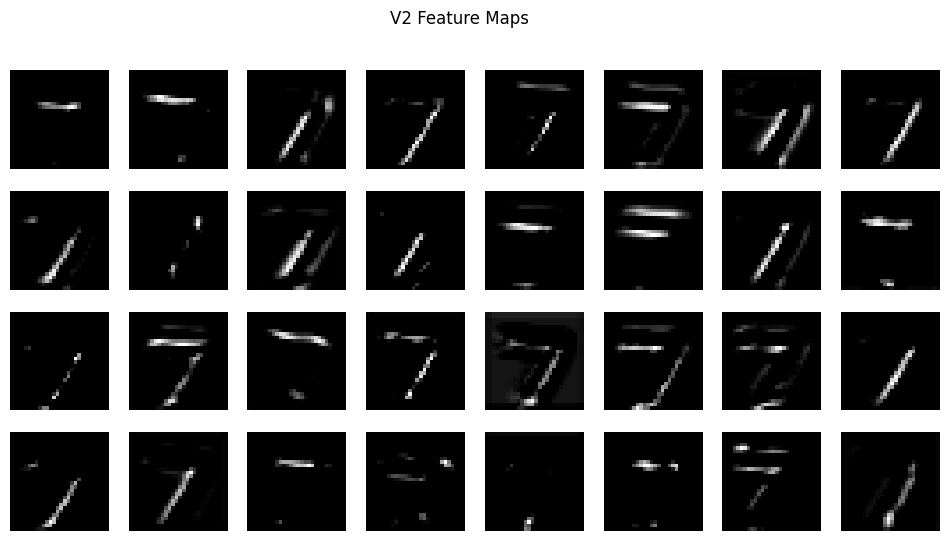

In [11]:
with torch.no_grad():
    v2_act = model.relu2(model.conv2(torch.tensor(v1_act).to(device))).cpu().numpy()

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.ravel()

for i in range(32):
    axes[i].imshow(v2_act[0, i], cmap='gray')
    axes[i].axis('off')

plt.suptitle("V2 Feature Maps")
plt.show()

In [ ]:
#展示某张图像如何激活 V1，并展示 V1 特征如何被 V2 组合成更复杂形状，类似单细胞记录V1：小区域、高方向敏感；V2：组合特征，如角点、曲线、交叉等

In [12]:
import copy
damaged = copy.deepcopy(model)

with torch.no_grad():
    damaged.conv1.weight[:8] = 0
    damaged.conv1.bias[:8] = 0

test(damaged, test_loader)

Test accuracy: 0.9113


In [ ]:
#损伤实验，“关闭”一部分 V1 神经元，测试识别性能下降多少。
#对应真实脑损伤研究：V1 损伤 → 人无法看到边缘 → 识别能力下降。